In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
dataPath = '/Users/Torben/Code/breathmetrics/sample_data.mat'
myData=sp.io.loadmat(dataPath)
resp=np.squeeze(myData['resp'])
srate = np.squeeze(myData['srate'])

In [155]:
class bmObject:
    def __init__(self, resp, srate, dataType):
        self.resp = resp
        self.srate = srate
        self.dataType = dataType
        self.featureEstimationsComplete=0
        self.featuresManuallyEdited=0
        self.smoothedRespiration = []
        self.time = []
        self.baselineCorrectedRespiration = []
        
        self.inhalePeaks = []
        self.exhaleTroughs = []
        self.peakInspiratoryFlows = []
        self.troughExpiratoryFlows = []
        
        self.inhaleOnsets = []
        self.exhaleOnsets = []
        
        self.inhalePauseOnsets = []
        self.exhalePauseOnsets = []
        
        self.inhaleOffsets = []
        self.exhaleOffsets = []
        
        self.inhaleDurations = []
        self.exhaleDurations = []
        
        # mean smoothing window is different for rodents and humans
        if dataType =='humanAirflow':
            self.smoothWinsize = 50

        elif dataType == 'humanBB':
            self.smoothWinsize = 50

        elif dataType == 'rodentAirflow':
            self.smoothWinsize = 10

        elif dataType == 'rodentThermocouple':
            self.smoothWinsize = 10
        else:
            print('todo error msg')
    
    
    # Preprocessing Methods
    
    # TODO
    #function validParams = checkClassInputs(Bm)


    
    def smoothResp(self):
        # de-noise data
        srateCorrectedSmoothedWindow = int(np.floor((srate/1000) * self.smoothWinsize))
        self.smoothedRespiration = self.running_mean(self.resp, srateCorrectedSmoothedWindow);
            
        # time is like fieldtrip. All events are indexed by point in
        # time vector.
        self.time = np.arange(0,len(self.resp)) / self.srate
            

    def correctRespirationToBaseline(self, method='simple', zScore=0, verbose=0):
        
        # default window size for sliding window mean is 60 seconds.
        swSize = 60; 
        
        detrendedResp=sp.signal.detrend(self.smoothedRespiration)
        respMean = self.smoothedRespiration - np.mean(self.smoothedRespiration)
    
        if method == 'simple':
            self.baselineCorrectedRespiration = respMean
            
        elif method == 'sliding':
            #for periodic drifts in data
            srateCorrectedSW = int(np.floor(self.srate * swSize));
        
            respSlidingMean=self.running_mean(self.smoothedRespiration, srateCorrectedSW);
                
            # subtract sliding mean from respiratory trace
            self.baselineCorrectedRespiration = self.smoothedRespiration - respSlidingMean
            
        if zScore == 1:
            self.baselineCorrectedRespiration = (self.baselineCorrectedRespiration - np.mean(self.baselineCorrectedRespiration)) / np.std(self.baselineCorrectedRespiration)
            
            
    def labelExtrema(self,simplify=0,verbose=0,customDecisionThreshold=0,swSizes=[]):
        # calls find extrema
        
        [putativePeaks, putativeTroughs] = self.findExtrema( customDecisionThreshold=customDecisionThreshold, swSizes=swSizes )
        
        # set nPeaks to nTroughs
        if simplify == 1:
            putativePeaks=putativePeaks[:len(putativeTroughs)]
            
        # The extrema represent the peak flow rates of inhales and exhales only in airflow recordings.
        if self.dataType == 'humanAirflow' or self.dataType == 'rodentAirflow':
            #indices of extrema
            self.inhalePeaks = putativePeaks
            self.exhaleTroughs = putativeTroughs

            # values of extrema
            self.peakInspiratoryFlows = self.baselineCorrectedRespiration[putativePeaks]
            self.troughExpiratoryFlows = self.baselineCorrectedRespiration[putativeTroughs]
            
            # In human breathing belt recordings, the peaks and troughs 
            # represent exhale and inhale onsets, respectively, because the
            # point where volume has maximized and instantaneously
            # decreases demarcates an exhale. This is unlike zero-crosses 
            # which demarcate breath onsets in airflow recordings.
            if self.dataType =='humanBB':
                
                self.inhaleOnsets = putativeTroughs;
                self.exhaleOnsets = putativePeaks;

            
            # In rodent thermocouple recordings, the peaks and troughs 
            # represent inhale and exhale onsets, respectively. Inhales
            # decrease the temperature in the nose and the onset is
            # demarcated by the first point this happens - the inflection
            # point of the peaks. Visa versa for exhales.
            elif self.dataType == 'rodentThermocouple':
                self.inhaleOnsets = putativePeaks;
                self.exhaleOnsets = putativeTroughs;
                
            
    # FEATURE EXTRACTION METHODS
    def findExtrema(self,customDecisionThreshold=0,swSizes=[]):
        
        resp=self.baselineCorrectedRespiration
        srateAdjust = self.srate/1000
        
        if len(swSizes)==0:
            if self.dataType == 'humanAirflow' or self.dataType == 'humanBB':
                srateAdjust = self.srate/1000
                swSizes = [int(np.floor(100*srateAdjust)),int(np.floor(300*srateAdjust)), int(np.floor(700*srateAdjust)), int(np.floor(1000*srateAdjust)), int(np.floor(5000*srateAdjust))]
                
            elif self.dataType == 'rodentAirflow' or self.dataType == 'rodentThermocouple':
                srateAdjust = self.srate/1000;
                swSizes = [int(np.floor(5*srateAdjust)), int(np.floor(10 * srateAdjust)), int(np.floor(20 * srateAdjust)), int(np.floor(50 * srateAdjust))];
        

        # pad end with zeros to include tail of data otherwise missed by big windows 
        padInd = min([len(resp)-1,max(swSizes)*2])
        flipInds=[len(resp)-padInd,len(resp)]
        lrFlipped = resp[flipInds[1]:flipInds[0]:-1]
        paddedResp = np.append(resp,lrFlipped)

        # initializing vector of all points where there is a peak or trough.
        swPeakVect = np.zeros([1, len(paddedResp)])
        swTroughVect = np.zeros([1, len(paddedResp)])

        # peaks and troughs must exceed this value. Sometimes algorithm finds mini peaks in flat traces
        peakThreshold = np.mean(resp) + np.std(resp) / 2
        troughThreshold = np.mean(resp) - np.std(resp) / 2

        # shifting window to be unbiased by starting point
        SHIFTS = np.arange(3)
        nWindows=len(swSizes)*len(SHIFTS)


        # find maxes in each sliding window, in each shift, and return peaks that are agreed upon by majority windows.

        # find extrema in each window of the data using each window size and offset
        for win in range(len(swSizes)):

            sw = swSizes[win];
            # cut off end of data based on sw size
            nIters  = int(np.floor(len(paddedResp) / sw)-1); 

            for shift in SHIFTS:
                # store index of max and min airflow in each window
                argmaxVect = np.zeros([1, nIters]);
                argminVect = np.zeros([1, nIters]);

                # shift starting point of sliding window to get unbiased maxes
                windowInit = int((sw - np.floor(sw / (shift+ 1))));

                # iterate over this window and find all maxima and minima
                windowIter=windowInit

                for i in range(nIters):
                    thisWindow = paddedResp[windowIter:windowIter + sw - 1]
                    maxVal = np.max(thisWindow)
                    maxInd = np.argmax(thisWindow)

                    # make sure peaks and troughs are real.
                    if maxVal > peakThreshold:
                        # index in window + location of window in original resp time
                        argmaxVect[0,i]= windowIter + maxInd-1

                    minVal = np.min(thisWindow)
                    minInd = np.argmin(thisWindow)
                    if minVal < troughThreshold:
                        # index in window + location of window in original resp time
                        argminVect[0,i]= windowIter+minInd-1

                    windowIter = windowIter + sw

                # add 1 to consensus vector at time index where peak was found by this window
                for i in range(len(argmaxVect[0])):
                    if argmaxVect[0,i] > 0:
                        timeIndex=int(argmaxVect[0,i])
                        swPeakVect[0,timeIndex] = swPeakVect[0,timeIndex]+1

                for i in range(len(argminVect[0])):
                    if argminVect[0,i] > 0:
                        timeIndex=int(argminVect[0,i])
                        swTroughVect[0,timeIndex] = swTroughVect[0,timeIndex]+1


        # find threshold that makes minimal difference in number of extrema found similar to idea of knee method of k-means clustering

        nPeaksFound = np.zeros([1, nWindows])
        nTroughsFound = np.zeros([1, nWindows])
        for threshold_ind in range(nWindows):
            nPeaksFound[0, threshold_ind] = int(np.sum(swPeakVect > threshold_ind))
            nTroughsFound[0, threshold_ind] = int(np.sum(swTroughVect > threshold_ind))

        bestPeakDiff = np.argmax(np.diff(nPeaksFound))
        bestTroughDiff = np.argmax(np.diff(nTroughsFound))

        if customDecisionThreshold > 0:
            bestDecisionThreshold = customDecisionThreshold
        else:
            bestDecisionThreshold = int(np.floor(np.mean([bestPeakDiff, bestTroughDiff])))


        # temporary peak inds. Each point where there is a real peak or trough
        peakInds = [i for i in range(swPeakVect.shape[1]) if swPeakVect[0,i] > bestDecisionThreshold]
        troughInds = [i for i in range(swTroughVect.shape[1]) if swTroughVect[0,i] > bestDecisionThreshold]
        
        # sometimes there are multiple peaks or troughs in series which shouldn't be possible. This loop ensures the series alternates peaks and troughs.

        # first we must find the first peak
        offByN = True;
        tri = 1;
        while offByN:
            if peakInds[tri] > troughInds[tri]:
                # remove this trough
                troughInds = troughInds[tri + 1:len(troughInds)]
            else:
                offByN=False;

        correctedPeaks = []
        correctedTroughs = []


        pki=1 # peak ind
        tri=1 # trough ind

        # variable to decide whether to record peak and trough inds.
        proceedCheck = 1

        # find peaks and troughs that alternate
        while pki <len(peakInds)-1 and tri < len(troughInds)-1:

            # time difference between peak and next trough
            peakTroughDiff = troughInds[tri] - peakInds[pki]

            # check if two peaks in a row
            peakPeakDiff = peakInds[pki+1] - peakInds[pki]

            if peakPeakDiff < peakTroughDiff:
                # if two peaks in a row, take larger peak
                nxtPk = np.argmax([paddedResp[peakInds[pki]], paddedResp[peakInds[pki+1]]])
                if nxtPk == 2:
                    # forget this peak. keep next one.
                    pki = pki+1
                else:
                    # forget next peak. keep this one.
                    peakInds = np.setdiff1d(peakInds, peakInds[pki+1])

                # there still might be another peak to remove so go back and check
                # again
                proceedCheck=0
            #end

            # if the next extrema is a trough, check for trough series
            if proceedCheck == 1:

                # check if trough is after this trough.
                troughTroughDiff = troughInds[tri + 1] - troughInds[tri]
                troughPeakDiff = peakInds[pki + 1] - troughInds[tri]

                if troughTroughDiff < troughPeakDiff:
                    # if two troughs in a row, take larger trough
                    nxtTr = np.argmin([paddedResp[troughInds[tri]], paddedResp[troughInds[tri + 1]]])
                    if nxtTr == 2:
                        # take second trough
                        tri = tri + 1
                    else:
                        # remove second trough
                        troughInds = np.setdiff1d(troughInds, troughInds[tri+1])

                    # there still might be another trough to remove so go back and 
                    # check again
                    proceedCheck=0

            # if both of the above pass we can save values
            if proceedCheck == 1:
                # if peaks aren't ahead of troughs
                if peakTroughDiff > 0:
                    #time_diff_pt = [time_diff_pt peak_trough_diff*srate_adjust];
                    correctedPeaks.append(peakInds[pki])
                    correctedTroughs.append(troughInds[tri])

                    # step forward
                    tri=tri+1;
                    pki=pki+1;
                else:
        #             # peaks got ahead of troughs. This shouldn't ever happen.
        #             disp('Peaks got ahead of troughs. This shouldnt happen.');
        #             disp(strcat('Peak ind: ', num2str(peakInds(pki))));
        #             disp(strcat('Trough ind: ', num2str(troughInds(tri))));
                    raise('unexpected error. stopping');

            proceedCheck=1;

        # remove any peaks or troughs in padding
        correctedPeaks = [i for i in correctedPeaks if i < len(resp)]
        correctedTroughs = [i for i in correctedTroughs if i < len(resp)]
        
        return correctedPeaks, correctedTroughs
        
        
    def findRespiratoryPausesAndOnsets(self,nBins=100):
        #FIND_RESPIRATORY_PAUSES_AND_ONSETS finds each breath onset and respiratory pause in the data, given the peaks and troughs

        #   Steps: 
        #   1. Find breath onsets for the first and last breath.
        #   2. For each trough-to-peak window, check if there is a respiratory pause.
        #   3. If no pause, then just find when the trace crosses baseline.
        #   4. if there is a pause, the amplitude range that it pauses over.
        #   5. Find onset and offset of pause.
        #   6. Find exhale onset in peak-to-trough window where it crosses baseline.
        #   7. Repeat.

        # 100 bins works well for data with sampling rates>100 Hz. 
        # Use different nBINS for data with lower sampling rates sampling rate is too slow.

        if nBins >= 100:
            maxPauseBins=5
        else:
            maxPauseBins=2

        resp=self.baselineCorrectedRespiration
        peaks=self.inhalePeaks
        troughs=self.exhaleTroughs

        # free parameter for sensitivity of calling something a pause or not.
        MAXIMUM_BIN_THRESHOLD = 5;

        inhaleOnsets = np.zeros([1, len(peaks)])
        exhaleOnsets = np.zeros([1, len(troughs)])

        # inhale pause onsets happen after inhales but before exhales
        # exhale pause onsets happen after exhales but before inhales 
        inhalePauseOnsets = np.zeros([1,len(peaks)])
        exhalePauseOnsets = np.zeros([1,len(troughs)]) 
        inhalePauseOnsets[:]=np.nan
        exhalePauseOnsets[:]=np.nan

        # thresholds the mode bin (cycle zero cross) must fall between.
        # fast breathing sometimes looks like a square wave so the mode is at the
        # head or the tail and doesn't reflect a breath onset.
        UPPER_THRESHOLD = np.round(nBins*.7)
        LOWER_THRESHOLD = np.round(nBins*.3)

        # If this fails, use average of trace
        SIMPLE_ZERO_CROSS = np.mean(resp)

        # first onset is special because it's not between two peaks. If there is 
        # lots of time before the first peak, limit it to within 4000 samples.

        # head and tail onsets are hard to estimate without lims. use average
        # breathing interval in these cases.
        TAIL_ONSET_LIMS = int(np.floor(np.mean(np.diff(peaks))))

        if peaks[0] > TAIL_ONSET_LIMS:
            firstZeroCrossBoundary = peaks[0]-TAIL_ONSET_LIMS
        else:
            firstZeroCrossBoundary=0

        # Estimate last zero cross (inhale onset) before first peak
        # If there is not a full cycle before the first peak, this estimation will be unreliable.
        THIS_WINDOW = resp[firstZeroCrossBoundary:peaks[0]]

        CUSTOM_BINS = np.linspace(min(THIS_WINDOW),max(THIS_WINDOW), nBins)
        [AMPLITUDE_VALUES, WINDOW_BINS] = np.histogram(THIS_WINDOW, bins=CUSTOM_BINS)
        MODE_BIN = np.argmax(AMPLITUDE_VALUES)
        ZERO_CROSS_THRESHOLD = WINDOW_BINS[MODE_BIN]

        if MODE_BIN < LOWER_THRESHOLD or MODE_BIN > UPPER_THRESHOLD:
            ZERO_CROSS_THRESHOLD = SIMPLE_ZERO_CROSS


        POSSIBLE_INHALE_INDS = THIS_WINDOW < ZERO_CROSS_THRESHOLD

        if sum(POSSIBLE_INHALE_INDS) > 0:
            # get the last index where this is true
            possibleInhaleOnsets=np.where(POSSIBLE_INHALE_INDS==True)
            INHALE_ONSET = possibleInhaleOnsets[0][-1]
            inhaleOnsets[0,0] = firstZeroCrossBoundary + INHALE_ONSET
        else:
            inhaleOnsets[0,0] = firstZeroCrossBoundary


        # percent of amplitudes added by including a bin compared to max bin
        BINNING_THRESHOLD = .25

        # cycle through each peak-peak window of respiration data
        for THIS_BREATH in range(len(peaks)-1):

            # Find next inhale onset and pause

            INHALE_WINDOW = resp[troughs[THIS_BREATH]:peaks[THIS_BREATH+1]]
            CUSTOM_BINS = np.linspace(min(INHALE_WINDOW),max(INHALE_WINDOW),nBins)
            [AMPLITUDE_VALUES, WINDOW_BINS] = np.histogram(INHALE_WINDOW, CUSTOM_BINS)
            MODE_BIN = np.argmax(AMPLITUDE_VALUES)

            MAX_BIN_RATIO = AMPLITUDE_VALUES[MODE_BIN]/np.mean(AMPLITUDE_VALUES);

            isExhalePause = ~(MODE_BIN < LOWER_THRESHOLD or MODE_BIN > UPPER_THRESHOLD or MAX_BIN_RATIO < MAXIMUM_BIN_THRESHOLD)

            if ~isExhalePause:
                # data does not cluster in the middle, indicating no respiratory pause. So just use baseline crossing as inhale onset
                THIS_INHALE_THRESHOLD = SIMPLE_ZERO_CROSS;

                # points where the trace crosses zero
                POSSIBLE_INHALE_INDS = INHALE_WINDOW > THIS_INHALE_THRESHOLD

                # find last point in half-cycle below threshold
                possibleInhaleOnsets=np.where(POSSIBLE_INHALE_INDS==True)
                INHALE_ONSET = possibleInhaleOnsets[0][0]

                # this is the inhale onset for the next peak so add 1 to keep indexing consistant
                exhalePauseOnsets[0, THIS_BREATH] = np.nan
                inhaleOnsets[0, THIS_BREATH + 1] = troughs[THIS_BREATH] + INHALE_ONSET

            else:
                # add bins to find good range of variance for this respiratory pause
                MIN_PAUSE_RANGE = WINDOW_BINS[MODE_BIN]
                MAX_PAUSE_RANGE = WINDOW_BINS[MODE_BIN+1]
                MAX_BIN_TOTAL = AMPLITUDE_VALUES[MODE_BIN]

                # add bins in positive direction
                for ADDITIONAL_BIN in range(maxPauseBins):
                    THIS_BIN = MODE_BIN-ADDITIONAL_BIN
                    nVALS_ADDED = AMPLITUDE_VALUES[THIS_BIN]
                    if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD:
                        MIN_PAUSE_RANGE = WINDOW_BINS[THIS_BIN]


                # add bins in negative direction
                for ADDITIONAL_BIN in range(maxPauseBins):
                    THIS_BIN = MODE_BIN+ADDITIONAL_BIN;
                    nVALS_ADDED = AMPLITUDE_VALUES[THIS_BIN]
                    if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD:
                        MAX_PAUSE_RANGE = WINDOW_BINS[THIS_BIN]


                PUTATIVE_PAUSE_INDS = np.intersect1d(np.where(INHALE_WINDOW > MIN_PAUSE_RANGE), np.where(INHALE_WINDOW < MAX_PAUSE_RANGE))

                if len(PUTATIVE_PAUSE_INDS)==0:
#                     print('no exhale pause found')

                    # actually no pause
                    THIS_INHALE_THRESHOLD = SIMPLE_ZERO_CROSS;
                    POSSIBLE_INHALE_INDS = INHALE_WINDOW > THIS_INHALE_THRESHOLD
                    possibleInhaleOnsets=np.where(POSSIBLE_INHALE_INDS==True)
                    INHALE_ONSET = possibleInhaleOnsets[0][0]

                    exhalePauseOnsets[0, THIS_BREATH] = np.nan
                    inhaleOnsets[0, THIS_BREATH + 1] = troughs[THIS_BREATH] + INHALE_ONSET

                else:
                    PAUSE_ONSET = PUTATIVE_PAUSE_INDS[0]-1
                    INHALE_ONSET = PUTATIVE_PAUSE_INDS[-1]+1
                    exhalePauseOnsets[0, THIS_BREATH] = troughs[THIS_BREATH] + PAUSE_ONSET
                    inhaleOnsets[0, THIS_BREATH + 1] = troughs[THIS_BREATH] + INHALE_ONSET


            # Find Next Exhale

            # troughs always follow peaks
            EXHALE_WINDOW = resp[peaks[THIS_BREATH]:troughs[THIS_BREATH]]
            CUSTOM_BINS=np.linspace(min(EXHALE_WINDOW),max(EXHALE_WINDOW),nBins)
            [AMPLITUDE_VALUES, WINDOW_BINS] = np.histogram(EXHALE_WINDOW, CUSTOM_BINS)
            MODE_BIN = np.argmax(AMPLITUDE_VALUES)
            MAX_BIN_RATIO = AMPLITUDE_VALUES[MODE_BIN]/np.mean(AMPLITUDE_VALUES)

            isInhalePause = ~(MODE_BIN < LOWER_THRESHOLD or MODE_BIN > UPPER_THRESHOLD or MAX_BIN_RATIO < MAXIMUM_BIN_THRESHOLD)

            if ~isInhalePause:
                # data does not cluster in the middle, indicating no respiratory
                # pause. So just use baseline crossing as inhale onset
                THIS_EXHALE_THRESHOLD = SIMPLE_ZERO_CROSS

                #points where the trace crosses zero
                POSSIBLE_EXHALE_INDS = np.where(EXHALE_WINDOW > THIS_EXHALE_THRESHOLD)

                # find last point in half-cycle below threshold
                EXHALE_ONSET = POSSIBLE_EXHALE_INDS[0][-1]
                # this is the exhale onset for the next trough

                inhalePauseOnsets[0, THIS_BREATH] = np.nan
                exhaleOnsets[0, THIS_BREATH] = peaks[THIS_BREATH] + EXHALE_ONSET

            else:
                # add bins to find good range of variance for this respiratory pause
                MIN_PAUSE_RANGE = WINDOW_BINS[MODE_BIN]
                MAX_PAUSE_RANGE = WINDOW_BINS[MODE_BIN+1]
                MAX_BIN_TOTAL = AMPLITUDE_VALUES[MODE_BIN]


                # add bins in positive direction
                for ADDITIONAL_BIN in range(maxPauseBins):
                    THIS_BIN = MODE_BIN-ADDITIONAL_BIN
                    nVALS_ADDED = AMPLITUDE_VALUES[THIS_BIN]
                    if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD:
                        MIN_PAUSE_RANGE = WINDOW_BINS[THIS_BIN]

                # add bins in negative direction
                for ADDITIONAL_BIN in range(maxPauseBins):
                    THIS_BIN = MODE_BIN+ADDITIONAL_BIN;
                    nVALS_ADDED = AMPLITUDE_VALUES[THIS_BIN]
                    if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD:
                        MAX_PAUSE_RANGE = WINDOW_BINS[THIS_BIN]


                PUTATIVE_PAUSE_INDS = np.intersect1d(np.where(EXHALE_WINDOW > MIN_PAUSE_RANGE), np.where(EXHALE_WINDOW < MAX_PAUSE_RANGE))
                if len(PUTATIVE_PAUSE_INDS)==0:
#                     print('no inhale pause found')
                    THIS_EXHALE_THRESHOLD = SIMPLE_ZERO_CROSS
                    POSSIBLE_EXHALE_INDS = np.where(EXHALE_WINDOW > THIS_EXHALE_THRESHOLD)

                    EXHALE_ONSET = POSSIBLE_EXHALE_INDS[0][-1]

                    inhalePauseOnsets[0, THIS_BREATH] = np.nan
                    exhaleOnsets[0, THIS_BREATH] = peaks[THIS_BREATH] + EXHALE_ONSET
                else:
                    PAUSE_ONSET = PUTATIVE_PAUSE_INDS[0]-1
                    EXHALE_ONSET = PUTATIVE_PAUSE_INDS[-1]+1

                    inhalePauseOnsets[0, THIS_BREATH] = peaks[THIS_BREATH] + PAUSE_ONSET
                    exhaleOnsets[0, THIS_BREATH] = peaks[THIS_BREATH] + EXHALE_ONSET


        # last exhale onset is also special because it's not in a peak-peak cycle
        # treat it similar to first inhale
        if len(resp) - peaks[-1] > TAIL_ONSET_LIMS:
            LAST_ZERO_CROSS_BOUNDARY = peaks[-1] + TAIL_ONSET_LIMS
        else:
            LAST_ZERO_CROSS_BOUNDARY = len(resp);

        EXHALE_WINDOW = resp[peaks[-1]:LAST_ZERO_CROSS_BOUNDARY]
        ZERO_CROSS_THRESHOLD = SIMPLE_ZERO_CROSS;

        POSSIBLE_EXHALE_INDS = EXHALE_WINDOW < ZERO_CROSS_THRESHOLD

        # unlikely but possible that no values fit this criteria
        if sum(POSSIBLE_EXHALE_INDS)>0:
            EXHALE_BEST_GUESS = np.where(POSSIBLE_EXHALE_INDS==True)
            exhaleOnsets[0,-1] = peaks[-1] + EXHALE_BEST_GUESS[0][0];
        else:
            # about half a cycle of respiration.
            exhaleOnsets[0,-1] = LAST_ZERO_CROSS_BOUNDARY;

        correctedInhaleOnsets = [int(i) for i in inhaleOnsets[0,:]]
        correctedExhaleOnsets = [int(i) for i in exhaleOnsets[0,:]]

        self.inhaleOnsets = correctedInhaleOnsets
        self.exhaleOnsets = correctedExhaleOnsets
        self.inhalePauseOnsets = inhalePauseOnsets
        self.exhalePauseOnsets = exhalePauseOnsets
        
        
    def findRespiratoryOffsets(self):
        inhaleOffsets = np.zeros([1,len(self.inhaleOnsets)])
        exhaleOffsets = np.zeros([1,len(self.exhaleOnsets)])

        # finding inhale offsets
        for bi in range(len(self.exhaleOnsets)):
            if np.isnan(self.inhalePauseOnsets[0,bi]):
                inhaleOffsets[0, bi] = self.exhaleOnsets[bi]-1
            else:
                inhaleOffsets[0, bi] = self.inhalePauseOnsets[0,bi]-1
        # finding exhale offsets
        for bi in range(len(self.exhaleOnsets) - 1):
            if np.isnan(self.exhalePauseOnsets[0,bi]):
                exhaleOffsets[0, bi] = self.inhaleOnsets[bi + 1]-1
            else:
                exhaleOffsets[0, bi] = self.exhalePauseOnsets[0,bi]-1

        # last exhale is different because there is no following inhale
        final_window = self.baselineCorrectedRespiration[exhaleOnsets[-1]:]
        putativeExhaleOffsets = np.where(final_window>0)

        # check that there is a real exhale end that it isn't artifact
        avgExhaleLen = np.mean(exhaleOffsets[0, :exhaleOffsets.shape[1]] - exhaleOnsets[:len(exhaleOnsets)-1])
        lowerLim = avgExhaleLen / 4;
        upperLim = avgExhaleLen * 1.75
        if putativeExhaleOffsets[0].size>0:
            if putativeExhaleOffsets[0] < lowerLim and putativeExhaleOffsets[0] >= upperLim:
                exhaleOffsets[0,-1] = exhaleOnsets[-1] + putativeExhaleOffsets[0] - 1

            else:
                # end of exhale cannot be calculated
                exhaleOffsets[0,-1] = np.nan
        else:
            exhaleOffsets[0,-1]= np.nan
                
        self.inhaleOffsets = inhaleOffsets
        self.exhaleOffsets = exhaleOffsets

        
    def findBreathDurations(self):

        inhaleDurations = np.zeros([1,len(self.inhaleOnsets)])
        exhaleDurations = np.zeros([1,len(self.exhaleOnsets)])
        inhalePauseDurations = np.zeros([1,len(self.inhaleOnsets)]);
        exhalePauseDurations = np.zeros([1,len(self.exhaleOnsets)]);

        # calculate inhale durations
        for i in range(len(self.inhaleOnsets)):
            if not np.isnan(self.inhaleOffsets[0,i]):
                inhaleDurations[0,i] = self.inhaleOffsets[0,i]-self.inhaleOnsets[i]
            else:
                inhaleDurations[0,i] = np.nan

        # calculate exhale durations
        for e in range(len(self.exhaleOnsets)):
            if not np.isnan(self.exhaleOffsets[0,e]):
                exhaleDurations[0,e] = self.exhaleOffsets[0,e]-self.exhaleOnsets[e]
            else:
                exhaleDurations[0,e] = np.nan;


        # calculate inhale pause durations
        for i in range(self.inhalePauseOnsets.shape[1]):
            if not np.isnan(self.inhalePauseOnsets[0,i]):
                inhalePauseDurations[0,i] = self.exhaleOnsets[i] - self.inhalePauseOnsets[0,i]
            else:
                inhalePauseDurations[0,i] = np.nan

        # calculate exhale pause durations
        for e in range(self.exhalePauseOnsets.shape[1]):
            if not np.isnan(self.exhalePauseOnsets[0,e]):
                if e<len(self.inhaleOnsets):
                    exhalePauseDurations[0,e] = self.inhaleOnsets[e+1] - self.exhalePauseOnsets[0,e]
                else:
                    exhalePauseDurations[0,e] = np.nan
            else:
                exhalePauseDurations[0,e] = np.nan


        # normalize back into real time and store
        self.inhaleDurations = inhaleDurations / self.srate
        self.exhaleDurations = exhaleDurations / self.srate
        self.inhalePauseDurations = inhalePauseDurations / self.srate
        self.exhalePauseDurations = exhalePauseDurations / self.srate
        
        
    # bookkeeping methods
    def running_mean(self, x, N):
        startInd=int(np.floor(N/2))
        cumsum = np.cumsum(np.insert(x, 0, 0)) 
        unPadded=(cumsum[N:] - cumsum[:-N]) / N
        smoothedData=np.zeros([1,len(x)])
        smoothedData[0,startInd:startInd+len(unPadded)]=unPadded
        smoothedData=smoothedData[0]

        return smoothedData
    
    def printVars(self):
        print(self.data, self.srate, self.dataType)
    

In [156]:
bm=bmObject(resp,srate,'humanAirflow')
bm.smoothResp()
bm.correctRespirationToBaseline()
bm.labelExtrema()
bm.findRespiratoryPausesAndOnsets()
bm.findRespiratoryOffsets()
bm.findBreathDurations()



In [157]:
bm.inhaleDurations

array([[7.246, 1.788, 2.018, 1.537, 1.639, 2.353, 1.895, 1.75 , 1.621,
        2.327, 1.88 , 2.041, 1.603, 1.613, 1.81 , 1.786, 1.728, 2.589,
        2.034, 1.981, 1.494, 1.275, 1.785, 1.213, 1.324, 1.73 , 2.08 ,
        1.699, 1.831, 2.118, 2.043, 1.453, 1.014, 1.582, 2.041, 1.779,
        0.794, 1.572, 2.268, 1.54 , 2.295, 1.649, 1.874, 1.717, 1.856,
        2.46 , 1.649, 2.001, 1.863, 1.808, 1.795, 1.863, 1.891, 2.255,
        1.463, 1.909, 2.064, 1.439, 1.749, 1.743, 1.368, 1.96 , 1.703,
        1.7  , 1.605, 1.571, 1.757, 1.469, 1.68 , 1.736, 1.918, 1.707,
        1.784, 1.644, 1.262, 1.848, 1.706, 1.226, 1.336, 1.478, 1.342,
        1.501, 1.893, 1.901, 2.162, 1.971, 1.835, 1.477, 1.586, 1.553,
        1.681, 1.63 , 1.655, 1.727, 1.845, 1.217, 1.544, 0.623, 1.72 ,
        1.596, 1.112, 1.361, 1.46 , 1.854, 1.67 , 2.221, 2.387, 1.903,
        2.013, 1.387, 1.835, 2.138, 2.099, 1.638, 1.506, 1.783, 1.684,
        2.036, 2.084, 2.153, 2.18 , 1.951, 1.42 , 1.711, 1.166, 1.532,
      

In [134]:
avgExhaleLen = np.mean(exhaleOffsets[0, :exhaleOffsets.shape[1]] - exhaleOnsets[:len(exhaleOnsets)-1])
print(avgExhaleLen)

1781.6046511627908


In [79]:
#FIND_RESPIRATORY_OFFSETS Finds where each inhale and exhale ends
inhaleOnsets=bm.inhaleOnsets
exhaleOnsets=bm.exhaleOnsets
inhalePauseOnsets=bm.inhalePauseOnsets
exhalePauseOnsets=bm.exhalePauseOnsets
resp=bm.baselineCorrectedRespiration

inhaleOffsets = np.zeros([1,len(inhaleOnsets)])
exhaleOffsets = np.zeros([1,len(exhaleOnsets)])

# finding inhale offsets
for bi in range(len(exhaleOnsets)):
    if np.isnan(inhalePauseOnsets[0,bi]):
        inhaleOffsets[0, bi] = exhaleOnsets[bi]-1
    else:
        inhaleOffsets[0, bi] = inhalePauseOnsets[0,bi]-1
# finding exhale offsets
for bi in range(len(exhaleOnsets) - 1):
    if np.isnan(exhalePauseOnsets[0,bi]):
        exhaleOffsets[0, bi] = inhaleOnsets[bi + 1]-1
    else:
        exhaleOffsets[0, bi] = exhalePauseOnsets[0,bi]-1


# last exhale is different because there is no following inhale
final_window = resp[exhaleOnsets[-1]:]
putativeExhaleOffsets = np.where(final_window>0)

# check that there is a real exhale end that it isn't artifact
avgExhaleLen = np.mean(exhaleOffsets[0, :exhaleOffsets.shape[1]-1] - exhaleOnsets[:len(exhaleOnsets)-1])
lowerLim = avgExhaleLen / 4;
upperLim = avgExhaleLen * 1.75
if putativeExhaleOffsets[0].size>0:
    if putativeExhaleOffsets[0] < lowerLim and putativeExhaleOffsets[0] >= upperLim:
        exhaleOffsets[0,-1] = exhaleOnsets[-1] + putativeExhaleOffsets[0] - 1
        
    else:
        # end of exhale cannot be calculated
        exhaleOffsets[0,-1] = np.nan


# putativeExhaleOffset = find(final_window > 0, 1, 'first');

In [76]:
bm.exhaleOnsets

[9274,
 13911,
 17736,
 22622,
 26679,
 31353,
 37109,
 42080,
 46901,
 51675,
 58012,
 63290,
 68376,
 73027,
 79210,
 83616,
 89271,
 93894,
 98981,
 104304,
 109678,
 114364,
 119635,
 124520,
 129332,
 133462,
 137173,
 142046,
 145795,
 149467,
 154460,
 159632,
 165021,
 170469,
 175744,
 180392,
 185298,
 192910,
 197326,
 202352,
 206962,
 212268,
 216929,
 221272,
 226898,
 233109,
 238780,
 245190,
 249597,
 254617,
 259041,
 264073,
 268543,
 273428,
 278114,
 281959,
 286196,
 290582,
 294878,
 299491,
 304832,
 310119,
 316237,
 320983,
 324625,
 330007,
 334772,
 339408,
 343691,
 347445,
 352649,
 357295,
 362675,
 368749,
 372747,
 377434,
 382420,
 387733,
 392324,
 397212,
 402732,
 406252,
 412063,
 417728,
 423226,
 428459,
 433626,
 438615,
 443246,
 448185,
 453361,
 457733,
 463700,
 468412,
 473838,
 479516,
 484087,
 489687,
 495749,
 501411,
 508415,
 512758,
 516621,
 521591,
 526529,
 531248,
 536762,
 542336,
 549511,
 554712,
 561085,
 564790,
 570248,
 57

In [59]:
final_window = resp[exhaleOnsets[-1]:]
possibleExhaleOffsets = np.where(final_window>0)
possibleExhaleOffsets

(array([], dtype=int64),)

In [22]:
function [inhaleOffsets,exhaleOffsets] = findRespiratoryOffsets(resp, ...
    inhaleOnsets, exhaleOnsets, inhalePauseOnsets, exhalePauseOnsets)

%FIND_RESPIRATORY_OFFSETS Finds where each inhale and exhale ends
    
inhaleOffsets = zeros(size(inhaleOnsets));
exhaleOffsets = zeros(size(exhaleOnsets));

% finding inhale offsets
for bi = 1:length(exhaleOnsets)
    if isnan(inhalePauseOnsets(bi))
        inhaleOffsets(1, bi) = exhaleOnsets(bi)-1;
    else
        inhaleOffsets(1, bi) = inhalePauseOnsets(bi)-1;
    end
end

% finding exhale offsets
for bi = 1:length(exhaleOnsets) - 1
    if isnan(exhalePauseOnsets(bi))
        exhaleOffsets(1, bi) = inhaleOnsets(bi + 1)-1;
    else
        exhaleOffsets(1, bi) = exhalePauseOnsets(bi)-1;
    end
end

% last exhale is different because there is no following inhale
final_window = resp(exhaleOnsets(end):end);
putativeExhaleOffset = find(final_window > 0, 1, 'first');

% check that there is a real exhale end that it isn't artifact
avgExhaleLen = mean(exhaleOffsets(1, 1:end-1) - exhaleOnsets(1, 1:end-1));
lowerLim = avgExhaleLen / 4;
upperLim = avgExhaleLen * 1.75;
if isempty(putativeExhaleOffset) || putativeExhaleOffset < lowerLim || ...
        putativeExhaleOffset >= upperLim
    % end of exhale cannot be calculated
    exhaleOffsets(1,end) = nan;
else
    exhaleOffsets(1,end) = exhaleOnsets(1,end) + putativeExhaleOffset - 1;
end


no inhale pause found
no exhale pause found
no inhale pause found
no inhale pause found
no inhale pause found


In [38]:
bm.exhaleTroughs

[9802,
 14160,
 18225,
 23202,
 27921,
 32623,
 37922,
 42513,
 47661,
 52887,
 58509,
 63751,
 69120,
 73640,
 80236,
 84432,
 89627,
 94597,
 99800,
 105069,
 110013,
 114962,
 120363,
 125044,
 130121,
 134018,
 137800,
 142522,
 146454,
 150201,
 155164,
 160589,
 165906,
 171036,
 176582,
 180873,
 186281,
 193422,
 198067,
 203001,
 207858,
 212758,
 217811,
 222404,
 227802,
 233976,
 239323,
 245833,
 250082,
 255293,
 259611,
 264551,
 269231,
 273945,
 278604,
 282455,
 286798,
 291233,
 295359,
 299936,
 305270,
 310545,
 316940,
 321716,
 325163,
 330826,
 335369,
 339973,
 344091,
 348033,
 353312,
 357810,
 363746,
 369504,
 373423,
 378151,
 383215,
 388282,
 392789,
 397709,
 403315,
 406836,
 412717,
 418263,
 423830,
 428973,
 434364,
 439218,
 443765,
 448801,
 453934,
 458251,
 464473,
 469183,
 474459,
 480150,
 484630,
 490350,
 496350,
 502106,
 508959,
 513213,
 517128,
 522066,
 526989,
 531855,
 537234,
 543227,
 550193,
 555341,
 561654,
 565951,
 570840,
 57

-0.000552548312218501
0.001060835545371279


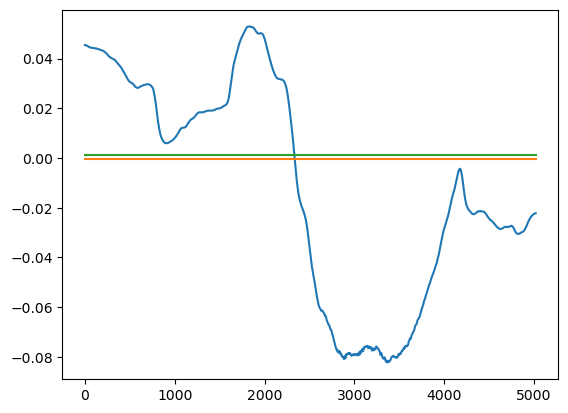

In [24]:
plt.plot(EXHALE_WINDOW)
plt.plot([0,len(EXHALE_WINDOW)],[MIN_PAUSE_RANGE,MIN_PAUSE_RANGE])
plt.plot([0,len(EXHALE_WINDOW)],[MAX_PAUSE_RANGE,MAX_PAUSE_RANGE])
print(MIN_PAUSE_RANGE)
print(MAX_PAUSE_RANGE)

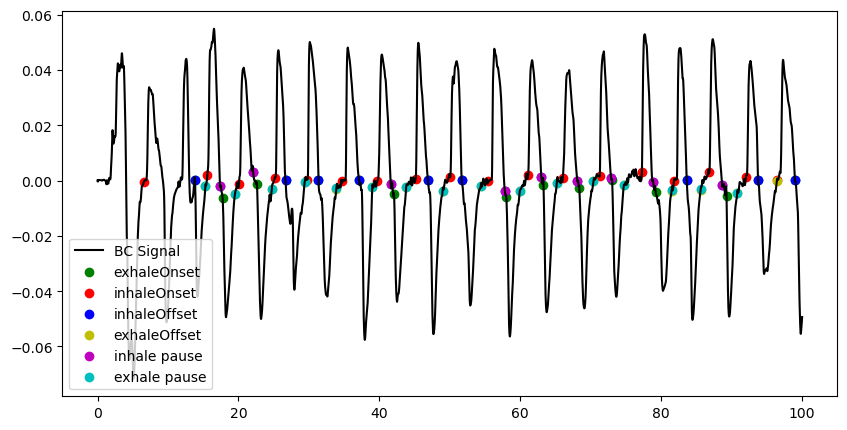

In [143]:
minPlotInd=0
maxPlotInd=100000
plotInds = np.arange(minPlotInd,maxPlotInd)
plotExhaleOnsets = [i for i in bm.exhaleOnsets if i>minPlotInd and i <maxPlotInd]
plotInhaleOnsets = [i for i in bm.inhaleOnsets if i>minPlotInd and i <maxPlotInd]
plotExhaleOffsets = [int(i) for i in bm.exhaleOffsets[0,:] if i>minPlotInd and i <maxPlotInd]
plotInhaleOffsets = [int(i) for i in bm.inhaleOffsets[0,:] if i>minPlotInd and i <maxPlotInd]

plotExhalePauseOnsets = [int(i) for i in bm.exhalePauseOnsets[0,:] if i>minPlotInd and i <maxPlotInd]
plotInhalePauseOnsets = [int(i) for i in bm.inhalePauseOnsets[0,:] if i>minPlotInd and i <maxPlotInd]

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time[plotInds],bm.baselineCorrectedRespiration[plotInds],'k-',label='BC Signal')
axs.scatter(bm.time[plotExhaleOnsets],bm.baselineCorrectedRespiration[plotExhaleOnsets],c='g',marker='o',label='exhaleOnset')
axs.scatter(bm.time[plotInhaleOnsets],bm.baselineCorrectedRespiration[plotInhaleOnsets],c='r',marker='o',label='inhaleOnset')

axs.scatter(bm.time[plotInhaleOffsets],bm.baselineCorrectedRespiration[plotInhaleOffsets],c='b',marker='o',label='inhaleOffset')
axs.scatter(bm.time[plotExhaleOffsets],bm.baselineCorrectedRespiration[plotExhaleOffsets],c='y',marker='o',label='exhaleOffset')

axs.scatter(bm.time[plotInhalePauseOnsets],bm.baselineCorrectedRespiration[plotInhalePauseOnsets],c='m',marker='o',label='inhale pause')
axs.scatter(bm.time[plotExhalePauseOnsets],bm.baselineCorrectedRespiration[plotExhalePauseOnsets],c='c',marker='o',label='exhale pause')

axs.legend()

In [144]:
bm.exhaleOffsets

array([[ 15290.,  19503.,  24715.,  29390.,  33894.,  38982.,  43798.,
         48959.,  54379.,  59909.,  65163.,  70362.,  74698.,  81463.,
         85588.,  90786.,  96394., 101000., 106313., 111436., 116391.,
        121679., 126159., 131178., 135038., 139159., 143550., 147261.,
        151091., 156149., 161299., 166892., 172266., 177927., 182041.,
        187498., 194598., 199354., 204714., 208837., 213760., 218889.,
        223552., 228965., 235085., 240627., 247101., 251590., 256485.,
        260946., 265722., 270619., 275175., 279696., 283623., 288189.,
        292532., 296569., 301312., 306599., 311683., 317962., 322594.,
        326423., 332257., 336479., 341278., 345150., 349252., 354222.,
        359261., 364775., 370585., 374408., 379282., 384272., 389599.,
        393840., 398945., 403863., 408182., 413895., 419643., 424911.,
        430189., 435719., 440480., 445120., 450064., 454977., 459475.,
        465541., 470518., 475654., 481379., 485967., 491598., 497747.,
      

In [ ]:
function [ inhaleOnsets, exhaleOnsets, inhalePauseOnsets, ...
    exhalePauseOnsets ] = ...
    findRespiratoryPausesAndOnsets( resp, myPeaks, myTroughs, nBINS )


% Assume that there is exactly one onset per breath
inhaleOnsets = zeros(1, length(myPeaks));
exhaleOnsets = zeros(1, length(myTroughs)); % changed on 4/11/20

% inhale pause onsets happen after inhales but before exhales
% exhale pause onsets happen after exhales but before inhales 
inhalePauseOnsets = zeros(1,length(myPeaks));
exhalePauseOnsets = zeros(1,length(myTroughs)); % changed on 4/11/20
inhalePauseOnsets(:)=nan;
exhalePauseOnsets(:)=nan;

% 100 bins works well for data with sampling rates>100 Hz. 
% use differen nBINS for data with lower sampling rates
% sampling rate is too slow.
if nargin<4
    nBINS = 100;
end
    
if nBINS >= 100
    maxPauseBins=5;
else
    maxPauseBins=2;
end

% free parameter for sensitivity of calling something a pause or not.
MAXIMUM_BIN_THRESHOLD = 5;

% thresholds the mode bin (cycle zero cross) must fall between.
% fast breathing sometimes looks like a square wave so the mode is at the
% head or the tail and doesn't reflect a breath onset.
UPPER_THRESHOLD = round(nBINS*.7);
LOWER_THRESHOLD = round(nBINS*.3);

% If this fails, use average of trace
SIMPLE_ZERO_CROSS = mean(resp);

% first onset is special because it's not between two peaks. If there is 
% lots of time before the first peak, limit it to within 4000 samples.

% head and tail onsets are hard to estimate without lims. use average
% breathing interval in these cases.
TAIL_ONSET_LIMS = floor(mean(diff(myPeaks)));


if myPeaks(1) > TAIL_ONSET_LIMS
    firstZeroCrossBoundary = myPeaks(1)-TAIL_ONSET_LIMS;
else
    firstZeroCrossBoundary=1;
end

% Estimate last zero cross (inhale onset) before first peak
% If there is not a full cycle before the first peak, this estimation will
% be unreliable.
THIS_WINDOW = resp(firstZeroCrossBoundary:myPeaks(1));
CUSTOM_BINS = linspace(min(THIS_WINDOW),max(THIS_WINDOW), nBINS);
[AMPLITUDE_VALUES, WINDOW_BINS] = hist(THIS_WINDOW, CUSTOM_BINS);
[~,MODE_BIN] = max(AMPLITUDE_VALUES);
ZERO_CROSS_THRESHOLD = WINDOW_BINS(MODE_BIN);
if MODE_BIN < LOWER_THRESHOLD || MODE_BIN > UPPER_THRESHOLD
    ZERO_CROSS_THRESHOLD = SIMPLE_ZERO_CROSS;
end
    
POSSIBLE_INHALE_INDS = THIS_WINDOW < ZERO_CROSS_THRESHOLD;
if sum(POSSIBLE_INHALE_INDS) > 0
    INHALE_ONSET = find(POSSIBLE_INHALE_INDS == 1, 1, 'last');
    inhaleOnsets(1,1) = firstZeroCrossBoundary + INHALE_ONSET;
else
    inhaleOnsets(1,1) = firstZeroCrossBoundary;
end

% cycle through each peak-peak window of respiration data
for THIS_BREATH = 1:length(myPeaks)-1
    
    % Find next inhale onset and pause
    
    INHALE_WINDOW = resp(myTroughs(THIS_BREATH):myPeaks(THIS_BREATH+1));
    CUSTOM_BINS = linspace(min(INHALE_WINDOW),max(INHALE_WINDOW),nBINS);
    [AMPLITUDE_VALUES, WINDOW_BINS] = hist(INHALE_WINDOW, CUSTOM_BINS);
    [~,MODE_BIN] = max(AMPLITUDE_VALUES);
    MAX_BIN_RATIO = AMPLITUDE_VALUES(MODE_BIN)/mean(AMPLITUDE_VALUES);
    isExhalePause = ~(MODE_BIN < LOWER_THRESHOLD || MODE_BIN > UPPER_THRESHOLD || MAX_BIN_RATIO < MAXIMUM_BIN_THRESHOLD);
    
    if ~isExhalePause
       % data does not cluster in the middle, indicating no respiratory
       % pause. So just use baseline crossing as inhale onset
       THIS_INHALE_THRESHOLD = SIMPLE_ZERO_CROSS;
       
       % points where the trace crosses zero
       POSSIBLE_INHALE_INDS = INHALE_WINDOW > THIS_INHALE_THRESHOLD;
       
       % find last point in half-cycle below threshold
       INHALE_ONSET = find( POSSIBLE_INHALE_INDS == 0, 1, 'last' );
       
       % this is the inhale onset for the next peak so add 1 to keep indexing
       % consistant
       exhalePauseOnsets(1, THIS_BREATH) = nan;
       inhaleOnsets(1, THIS_BREATH + 1) = myTroughs( THIS_BREATH ) + INHALE_ONSET;
        
    else
        % add bins to find good range of variance for this respiratory pause
        MIN_PAUSE_RANGE = WINDOW_BINS(MODE_BIN);
        MAX_PAUSE_RANGE = WINDOW_BINS(MODE_BIN+1);
        MAX_BIN_TOTAL = AMPLITUDE_VALUES(MODE_BIN);
        
        % percent of amplitudes added by including a bin compared to max bin
        BINNING_THRESHOLD = .25; 
        
        % add bins in positive direction
        for ADDITIONAL_BIN = 1:maxPauseBins
            THIS_BIN = MODE_BIN-ADDITIONAL_BIN;
            nVALS_ADDED = AMPLITUDE_VALUES(THIS_BIN);
            if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD
                MIN_PAUSE_RANGE = WINDOW_BINS(THIS_BIN);
            end
        end
        
        % add bins in negative direction
        for ADDITIONAL_BIN = 1:maxPauseBins
            THIS_BIN = MODE_BIN+ADDITIONAL_BIN;
            nVALS_ADDED = AMPLITUDE_VALUES(THIS_BIN);
            if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD
                MAX_PAUSE_RANGE = WINDOW_BINS(THIS_BIN);
            end
        end
            
        PUTATIVE_PAUSE_INDS = find(INHALE_WINDOW > MIN_PAUSE_RANGE  & INHALE_WINDOW<MAX_PAUSE_RANGE);
        PAUSE_ONSET = PUTATIVE_PAUSE_INDS(1)-1;
        INHALE_ONSET = PUTATIVE_PAUSE_INDS(end)+1;
        exhalePauseOnsets(1, THIS_BREATH) = myTroughs( THIS_BREATH ) + PAUSE_ONSET;
        inhaleOnsets(1, THIS_BREATH + 1) = myTroughs( THIS_BREATH ) + INHALE_ONSET;
    end
    
    % Find Next Exhale
    
    % troughs always follow peaks
    EXHALE_WINDOW = resp(myPeaks(THIS_BREATH):myTroughs(THIS_BREATH));
    CUSTOM_BINS=linspace(min(EXHALE_WINDOW),max(EXHALE_WINDOW),nBINS);
    [AMPLITUDE_VALUES, WINDOW_BINS] = hist(EXHALE_WINDOW, CUSTOM_BINS);
    [~,MODE_BIN] = max(AMPLITUDE_VALUES);
    MAX_BIN_RATIO = AMPLITUDE_VALUES(MODE_BIN)/mean(AMPLITUDE_VALUES);
    
    isInhalePause = ~(MODE_BIN < LOWER_THRESHOLD || MODE_BIN > UPPER_THRESHOLD || MAX_BIN_RATIO < MAXIMUM_BIN_THRESHOLD);
    
    if ~isInhalePause
       % data does not cluster in the middle, indicating no respiratory
       % pause. So just use baseline crossing as inhale onset
       THIS_EXHALE_THRESHOLD = SIMPLE_ZERO_CROSS;
       
       % points where the trace crosses zero
       POSSIBLE_EXHALE_INDS = EXHALE_WINDOW > THIS_EXHALE_THRESHOLD;
       
       % find last point in half-cycle below threshold
       EXHALE_ONSET = find( POSSIBLE_EXHALE_INDS == 1, 1, 'last' );
       % this is the exhale onset for the next trough
       
       inhalePauseOnsets(1, THIS_BREATH) = nan;
       exhaleOnsets(1, THIS_BREATH) = myPeaks( THIS_BREATH ) + EXHALE_ONSET;
    else
        % add bins to find good range of variance for this respiratory pause
        MIN_PAUSE_RANGE = WINDOW_BINS(MODE_BIN);
        MAX_PAUSE_RANGE = WINDOW_BINS(MODE_BIN+1);
        MAX_BIN_TOTAL = AMPLITUDE_VALUES(MODE_BIN);
        % percent of amplitudes added by including a bin compared to max bin
        BINNING_THRESHOLD = .25; 
        
        % add bins in positive direction
        for ADDITIONAL_BIN = 1:5
            THIS_BIN = MODE_BIN-ADDITIONAL_BIN;
            nVALS_ADDED = AMPLITUDE_VALUES(THIS_BIN);
            if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD
                MIN_PAUSE_RANGE = WINDOW_BINS(THIS_BIN);
            end
        end
        
        % add bins in negative direction
        for ADDITIONAL_BIN = 1:5
            THIS_BIN = MODE_BIN+ADDITIONAL_BIN;
            nVALS_ADDED = AMPLITUDE_VALUES(THIS_BIN);
            if nVALS_ADDED > MAX_BIN_TOTAL * BINNING_THRESHOLD
                MAX_PAUSE_RANGE = WINDOW_BINS(THIS_BIN);
            end
        end
            
        PUTATIVE_PAUSE_INDS = find(EXHALE_WINDOW > MIN_PAUSE_RANGE  & EXHALE_WINDOW < MAX_PAUSE_RANGE);
        PAUSE_ONSET = PUTATIVE_PAUSE_INDS(1)-1;
        EXHALE_ONSET = PUTATIVE_PAUSE_INDS(end)+1;
        inhalePauseOnsets(1, THIS_BREATH) = myPeaks( THIS_BREATH ) + PAUSE_ONSET;
        exhaleOnsets(1, THIS_BREATH) = myPeaks( THIS_BREATH ) + EXHALE_ONSET;
    end 
end

% last exhale onset is also special because it's not in a peak-peak cycle
% treat it similar to first inhale
if length(resp) - myPeaks(end) > TAIL_ONSET_LIMS
    LAST_ZERO_CROSS_BOUNDARY = myPeaks(end) + TAIL_ONSET_LIMS;
else
    LAST_ZERO_CROSS_BOUNDARY = length(resp);
end

EXHALE_WINDOW = resp(myPeaks(end):LAST_ZERO_CROSS_BOUNDARY);
ZERO_CROSS_THRESHOLD = SIMPLE_ZERO_CROSS;

POSSIBLE_EXHALE_INDS = EXHALE_WINDOW < ZERO_CROSS_THRESHOLD;

% unlikely but possible that no values fit this criteria
if sum(POSSIBLE_EXHALE_INDS)>0
    EXHALE_BEST_GUESS = find(POSSIBLE_EXHALE_INDS == 1, 1, 'first');
    exhaleOnsets(1,end) = myPeaks(end) + EXHALE_BEST_GUESS;
else
    % about half a cycle of respiration.
    exhaleOnsets(1,end) = LAST_ZERO_CROSS_BOUNDARY;
end


In [5]:
zScore=1;
verbose=1;
bcMethod = 'sliding'

bm.smoothResp()
print(len(bm.baselineCorrectedRespiration))
print(len(resp))

print(len(bm.smoothedRespiration))
bm.correctRespirationToBaseline(bcMethod,zScore,verbose)
print(len(bm.baselineCorrectedRespiration))

660001
660001
660001
660001


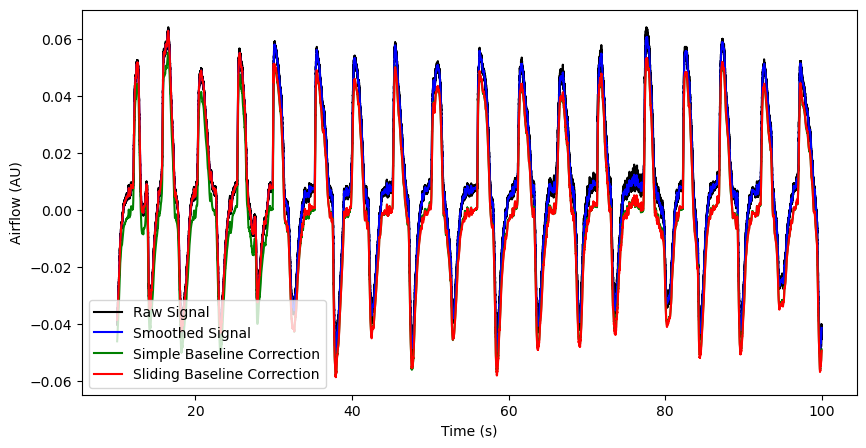

In [6]:
# compare resp trace using different smoothing methods

plotInds = np.arange(10000,100000)
bm.correctRespirationToBaseline('simple',0,verbose)
simpleBC=bm.baselineCorrectedRespiration

bm.correctRespirationToBaseline('sliding',0,verbose)
slidingBC=bm.baselineCorrectedRespiration

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time[plotInds],resp[plotInds],'k-',label='Raw Signal')
axs.plot(bm.time[plotInds],bm.smoothedRespiration[plotInds],'b-',label='Smoothed Signal')
axs.plot(bm.time[plotInds],simpleBC[plotInds],'g-',label='Simple Baseline Correction')
axs.plot(bm.time[plotInds],slidingBC[plotInds],'r-',label='Sliding Baseline Correction')
axs.legend()


axs.set_xlabel('Time (s)')
axs.set_ylabel('Airflow (AU)');

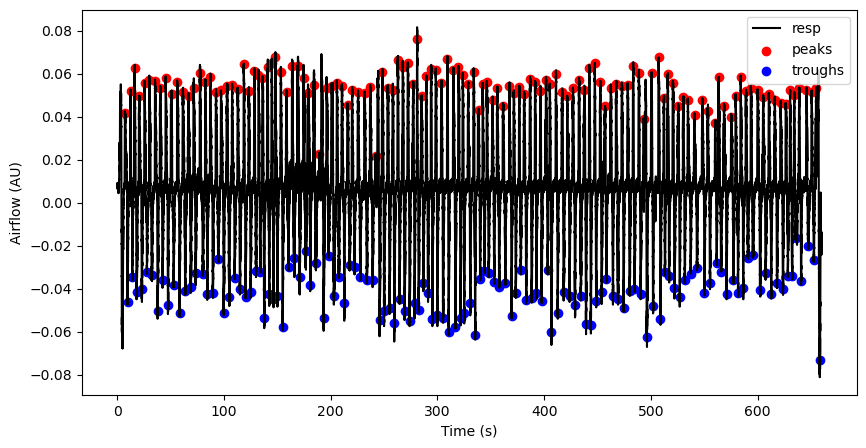

In [7]:
# do peaks and troughs look right?

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time,resp,'k-',label='resp')
axs.scatter(bm.time[bm.inhalePeaks],resp[bm.inhalePeaks],c='r',marker='o',label='peaks')
axs.scatter(bm.time[bm.exhaleTroughs],resp[bm.exhaleTroughs],c='b',marker='o',label='troughs')
# axs.scatter(bm.time[bm.inhaleOnsets],resp[bm.inhaleOnsets],c='r',marker='o',label='inhale onset')
# axs.scatter(bm.time[bm.exhaleOnsets],resp[bm.exhaleOnsets],c='b',marker='o',label='troughs')

axs.legend()


axs.set_xlabel('Time (s)')
axs.set_ylabel('Airflow (AU)');

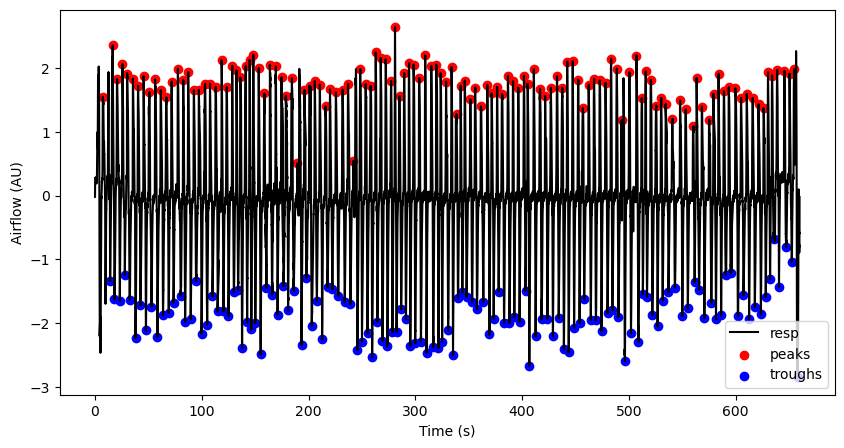

In [328]:
# do peaks and troughs look right?

WIDTH_SIZE=10;
HEIGHT_SIZE=5;

fig, axs = plt.subplots(1,1,figsize=(WIDTH_SIZE,HEIGHT_SIZE))
axs.plot(bm.time,resp,'k-',label='resp')
axs.scatter(bm.time[correctedPeaks],resp[correctedPeaks],c='r',marker='o',label='peaks')
axs.scatter(bm.time[correctedTroughs],resp[correctedTroughs],c='b',marker='o',label='troughs')

axs.legend()


axs.set_xlabel('Time (s)')
axs.set_ylabel('Airflow (AU)');

In [ ]:

% find maxes in each sliding window, in each shift, and return peaks that
% are agreed upon by majority windows.

% find extrema in each window of the data using each window size and offset
for win = 1:length(swSizes)
    
    sw = swSizes(win);
    % cut off end of data based on sw size
    nIters  = floor(length(paddedResp) / sw)-1; 
    
    for shift = SHIFTS
        % store maxima and minima of each window
        argmaxVect = zeros(1, nIters);
        argminVect = zeros(1, nIters);
        
        %shift starting point of sliding window to get unbiased maxes
        windowInit = (sw - floor(sw / shift)) + 1;
         
        % iterate by this window size and find all maxima and minima
        windowIter=windowInit;
        for i = 1:nIters
            thisWindow = paddedResp(1, windowIter:windowIter + sw - 1);
            [maxVal,maxInd] = max(thisWindow);
            
            % make sure peaks and troughs are real.
            if maxVal > peakThreshold
                % index in window + location of window in original resp time
                argmaxVect(1,i)=windowIter + maxInd-1;
            end
            [minVal,minInd] = min(thisWindow);
            if minVal < troughThreshold
                % index in window + location of window in original resp time
                argminVect(1,i)=windowIter+minInd-1;
            end
            windowIter = windowIter + sw;
        end
        % add 1 to consensus vector
        swPeakVect(1, nonzeros(argmaxVect)) = ...
            swPeakVect(1,nonzeros(argmaxVect)) + 1;
        swTroughVect(1, nonzeros(argminVect)) = ...
            swTroughVect(1, nonzeros(argminVect)) + 1;
    end
end


% find threshold that makes minimal difference in number of extrema found
% similar idea to knee method of k-means clustering

nPeaksFound = zeros(1, nWindows);
nTroughsFound = zeros(1, nWindows);
for threshold_ind = 1:nWindows
    nPeaksFound(1, threshold_ind) = sum(swPeakVect > threshold_ind);
    nTroughsFound(1, threshold_ind) = sum(swTroughVect > threshold_ind);
end

[~,bestPeakDiff] = max(diff(nPeaksFound));
[~,bestTroughDiff] = max(diff(nTroughsFound));

if customDecisionThreshold>0
    bestDecisionThreshold = customDecisionThreshold;
else
    bestDecisionThreshold = floor(mean([bestPeakDiff, bestTroughDiff]));
end

% % temporary peak inds. Eacy point where there is a real peak or trough
peakInds = find(swPeakVect >= bestDecisionThreshold);
troughInds = find(swTroughVect >= bestDecisionThreshold);


% sometimes there are multiple peaks or troughs in series which shouldn't 
% be possible. This loop ensures the series alternates peaks and troughs.

% first we must find the first peak
offByN = 1;
tri = 1;
while offByN
    if peakInds(tri)> troughInds(tri)
        troughInds = troughInds(1, tri + 1:end);
    else
        offByN=0;
    end
end

correctedPeaks = [];
correctedTroughs = [];


pki=1; % peak ind
tri=1; % trough ind

% variable to decide whether to record peak and trough inds.
proceedCheck = 1; 

% find peaks and troughs that alternate
while pki <length(peakInds)-1 && tri<length(troughInds)-1
    
    % time difference between peak and next trough
    peakTroughDiff = troughInds(tri) - peakInds(pki);
    
    % check if two peaks in a row
    peakPeakDiff = peakInds(pki+1) - peakInds(pki);
    
    if peakPeakDiff < peakTroughDiff
        % if two peaks in a row, take larger peak
        [~, nxtPk] = max([paddedResp(peakInds(pki)), ...
            paddedResp(peakInds(pki+1))]);
        if nxtPk == 2
            % forget this peak. keep next one.
            pki = pki+1;
        else
            % forget next peak. keep this one.
            peakInds = setdiff(peakInds, peakInds(1, pki+1));
        end
        % there still might be another peak to remove so go back and check
        % again
        proceedCheck=0;
    end
    
    % if the next extrema is a trough, check for trough series
    if proceedCheck == 1
        
        % check if trough is after this trough.
        troughTroughDiff = troughInds(tri + 1) - troughInds(tri);
        troughPeakDiff = peakInds(pki + 1) - troughInds(tri);
        
        if troughTroughDiff < troughPeakDiff
            % if two troughs in a row, take larger trough
            [~, nxtTr] = min([paddedResp(troughInds(tri)), ...
                paddedResp(troughInds(tri + 1))]);
            if nxtTr == 2
                % take second trough
                tri = tri + 1;
            else
                % remove second trough
                troughInds = setdiff(troughInds, troughInds(1, tri + 1));
            end
            % there still might be another trough to remove so go back and 
            % check again
            proceedCheck=0;
        end
    end
    
    % if both of the above pass we can save values
    if proceedCheck == 1
        % if peaks aren't ahead of troughs
        if peakTroughDiff > 0
            %time_diff_pt = [time_diff_pt peak_trough_diff*srate_adjust];
            correctedPeaks = [correctedPeaks peakInds(pki)];
            correctedTroughs = [correctedTroughs troughInds(tri)];
            
            % step forward
            tri=tri+1;
            pki=pki+1;
        else
            % peaks got ahead of troughs. This shouldn't ever happen.
            disp('Peaks got ahead of troughs. This shouldnt happen.');
            disp(strcat('Peak ind: ', num2str(peakInds(pki))));
            disp(strcat('Trough ind: ', num2str(troughInds(tri))));
            raise('unexpected error. stopping');
        end
    end
    proceedCheck=1;
end

% remove any peaks or troughs in padding
correctedPeaks = correctedPeaks(correctedPeaks < length(resp));
correctedTroughs = correctedTroughs(correctedTroughs < length(resp));

end